<a href="https://colab.research.google.com/github/aninsung/Machine-Learning-Programming/blob/main/6%EC%A3%BC%EC%B0%A8_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#(과제 수정공지)
##1. PulseDB에서 2000세그먼트 이상 환자를 선택(대략 250메가 이상을 선택하면 안전)
## 2. 각자 다른 환자를 선택해야 함 (선택후 pxxxxx) 이런식으로 겹치지 않도록 단톡방에 공지
##3. 가능한 혈압 정상+고혈압전단계 범위 (SBP 130- 140 이하, DBP 80이상) 선택이 모델성능에 유리.
##4. 전 구간의 SBP, DBP를 그래프 표시(구간의 변동을 알수 있도록)
##5. 전체구간을 오버래핑 없이 5구간으로 나누고 320세그먼트(훈련) 40(검증) 40(테스트) 를 시간 순서대로 사용
##6. MAE값 구하기. 제출기한 기말고사 11월 16일까지.
##7. 환자선택은 올리는 순대로 (동일한 환자 있을 경우 제가 지적)

In [1]:
!pip install tensorflow

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


총 500개의 세그먼트 로드 중...

=== 혈압 데이터 통계 ===
세그먼트 수: 500

SBP (수축기 혈압):
  - 평균: 124.91 mmHg
  - 최소: 100.14 mmHg
  - 최대: 145.01 mmHg
  - 표준편차: 5.93 mmHg

DBP (이완기 혈압):
  - 평균: 74.78 mmHg
  - 최소: 64.28 mmHg
  - 최대: 85.97 mmHg
  - 표준편차: 3.62 mmHg


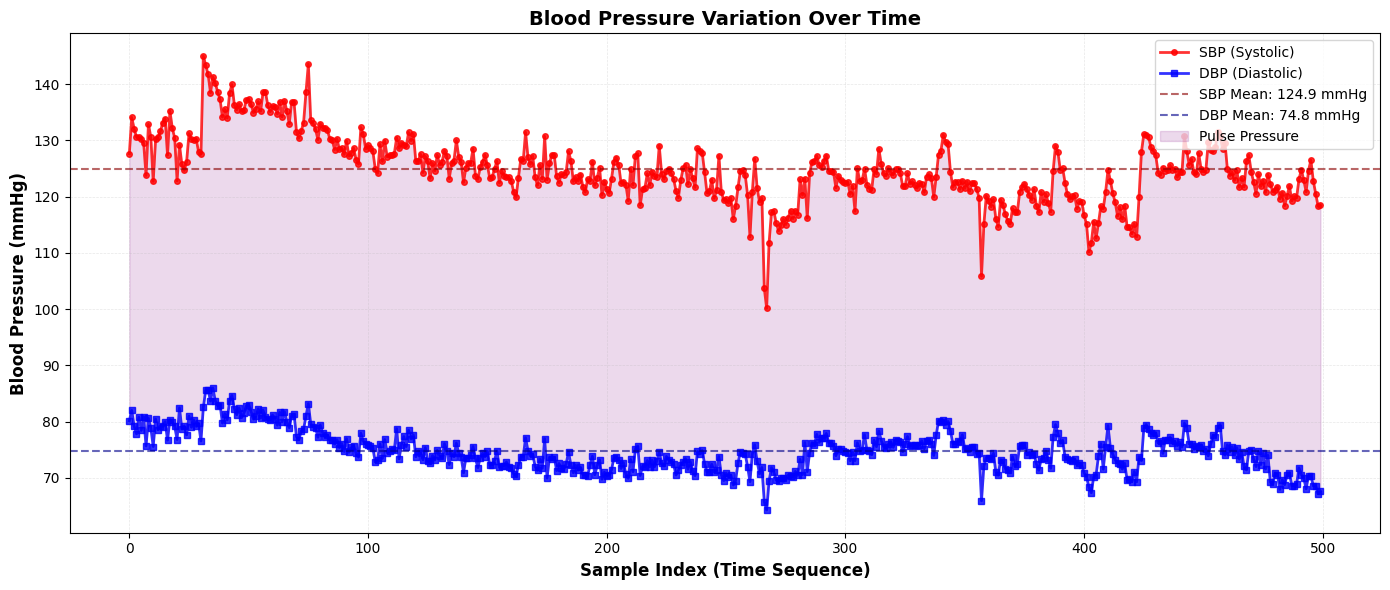


로드 완료: 500개의 PPG 세그먼트


In [3]:
def load_and_display_bp(mat_path, segment_limit=None):
    """
    MAT 파일에서 PPG 세그먼트와 혈압(SBP, DBP) 데이터를 로드하고 표시

    Args:
        mat_path: .mat 파일 경로
        segment_limit: 로드할 최대 세그먼트 수 (None이면 전체)
    """
    segments, sbp_list, dbp_list = [], [], []

    # MAT 파일 로드
    with h5py.File(mat_path, 'r') as f:
        refs = f['Subj_Wins']['PPG_F'][0]
        sbps = f['Subj_Wins']['SegSBP'][0]
        dbps = f['Subj_Wins']['SegDBP'][0]

        total = min(len(refs), segment_limit) if segment_limit else len(refs)

        print(f"총 {total}개의 세그먼트 로드 중...")

        for i in range(total):
            ppg = f[refs[i]][()].squeeze().astype(np.float32)
            sbp = float(f[sbps[i]][()][0][0])
            dbp = float(f[dbps[i]][()][0][0])

            segments.append(ppg)
            sbp_list.append(sbp)
            dbp_list.append(dbp)

    # 통계 출력
    print(f"\n=== 혈압 데이터 통계 ===")
    print(f"세그먼트 수: {len(segments)}")
    print(f"\nSBP (수축기 혈압):")
    print(f"  - 평균: {np.mean(sbp_list):.2f} mmHg")
    print(f"  - 최소: {np.min(sbp_list):.2f} mmHg")
    print(f"  - 최대: {np.max(sbp_list):.2f} mmHg")
    print(f"  - 표준편차: {np.std(sbp_list):.2f} mmHg")

    print(f"\nDBP (이완기 혈압):")
    print(f"  - 평균: {np.mean(dbp_list):.2f} mmHg")
    print(f"  - 최소: {np.min(dbp_list):.2f} mmHg")
    print(f"  - 최대: {np.max(dbp_list):.2f} mmHg")
    print(f"  - 표준편차: {np.std(dbp_list):.2f} mmHg")

    # 시각화
    plot_bp_combined_timeseries(sbp_list, dbp_list)

    return segments, sbp_list, dbp_list


def plot_bp_distribution(sbp_list, dbp_list):
    """혈압 분포 히스토그램"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.hist(sbp_list, bins=30, color='red', alpha=0.7, edgecolor='black')
    ax1.set_xlabel('SBP (mmHg)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('SBP Distribution')
    ax1.axvline(np.mean(sbp_list), color='darkred', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(sbp_list):.1f}')
    ax1.legend()
    ax1.grid(alpha=0.3)

    ax2.hist(dbp_list, bins=30, color='blue', alpha=0.7, edgecolor='black')
    ax2.set_xlabel('DBP (mmHg)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('DBP Distribution')
    ax2.axvline(np.mean(dbp_list), color='darkblue', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(dbp_list):.1f}')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_bp_scatter(sbp_list, dbp_list):
    """SBP vs DBP 산점도"""
    plt.figure(figsize=(8, 6))
    plt.scatter(sbp_list, dbp_list, alpha=0.6, s=50, c=range(len(sbp_list)),
                cmap='viridis', edgecolors='black', linewidth=0.5)

    plt.xlabel('SBP (mmHg)', fontsize=12)
    plt.ylabel('DBP (mmHg)', fontsize=12)
    plt.title('SBP vs DBP Relationship', fontsize=14)
    plt.colorbar(label='Sample Index')
    plt.grid(alpha=0.3)

    # 추세선
    z = np.polyfit(sbp_list, dbp_list, 1)
    p = np.poly1d(z)
    plt.plot(sorted(sbp_list), p(sorted(sbp_list)), "r--",
             linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_bp_timeseries(sbp_list, dbp_list):
    """시간 순서에 따른 SBP/DBP 변화 그래프"""
    time_idx = np.arange(len(sbp_list))

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

    # SBP 시계열
    ax1.plot(time_idx, sbp_list, color='red', linewidth=1.5,
             marker='o', markersize=3, alpha=0.7, label='SBP')
    ax1.axhline(np.mean(sbp_list), color='darkred', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(sbp_list):.1f}')
    ax1.fill_between(time_idx, sbp_list, alpha=0.2, color='red')
    ax1.set_ylabel('SBP (mmHg)', fontsize=12, fontweight='bold')
    ax1.set_title('Systolic Blood Pressure Over Time', fontsize=14)
    ax1.legend(loc='upper right')
    ax1.grid(alpha=0.3)

    # DBP 시계열
    ax2.plot(time_idx, dbp_list, color='blue', linewidth=1.5,
             marker='o', markersize=3, alpha=0.7, label='DBP')
    ax2.axhline(np.mean(dbp_list), color='darkblue', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(dbp_list):.1f}')
    ax2.fill_between(time_idx, dbp_list, alpha=0.2, color='blue')
    ax2.set_xlabel('Sample Index (Time Sequence)', fontsize=12)
    ax2.set_ylabel('DBP (mmHg)', fontsize=12, fontweight='bold')
    ax2.set_title('Diastolic Blood Pressure Over Time', fontsize=14)
    ax2.legend(loc='upper right')
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_bp_combined_timeseries(sbp_list, dbp_list):
    """SBP와 DBP를 하나의 그래프에 표시 (흰색 배경)"""
    time_idx = np.arange(len(sbp_list))

    fig = plt.figure(figsize=(14, 6), facecolor='white')
    ax = fig.add_subplot(111, facecolor='white')

    # SBP와 DBP 라인 플롯
    ax.plot(time_idx, sbp_list, color='red', linewidth=2,
            marker='o', markersize=4, alpha=0.8, label='SBP (Systolic)')
    ax.plot(time_idx, dbp_list, color='blue', linewidth=2,
            marker='s', markersize=4, alpha=0.8, label='DBP (Diastolic)')

    # 평균선
    ax.axhline(np.mean(sbp_list), color='darkred', linestyle='--',
               linewidth=1.5, alpha=0.6, label=f'SBP Mean: {np.mean(sbp_list):.1f} mmHg')
    ax.axhline(np.mean(dbp_list), color='darkblue', linestyle='--',
               linewidth=1.5, alpha=0.6, label=f'DBP Mean: {np.mean(dbp_list):.1f} mmHg')

    # 영역 채우기 (맥압 표시)
    ax.fill_between(time_idx, sbp_list, dbp_list, alpha=0.15, color='purple',
                    label='Pulse Pressure')

    ax.set_xlabel('Sample Index (Time Sequence)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Blood Pressure (mmHg)', fontsize=12, fontweight='bold')
    ax.set_title('Blood Pressure Variation Over Time', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10, frameon=True, facecolor='white')
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

    # 배경색 명시적으로 흰색 설정
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')

    plt.tight_layout()
    plt.show()


def plot_sample_ppg_with_bp(segments, sbp_list, dbp_list, n_samples=5):
    """샘플 PPG 신호와 혈압 값 표시"""
    n = min(n_samples, len(segments))
    fig, axes = plt.subplots(n, 1, figsize=(12, 3*n))

    if n == 1:
        axes = [axes]

    for i in range(n):
        ppg = segments[i]
        sbp = sbp_list[i]
        dbp = dbp_list[i]

        axes[i].plot(ppg, color='black', linewidth=1.2)
        axes[i].set_title(f'Sample {i+1} | SBP: {sbp:.1f} mmHg | DBP: {dbp:.1f} mmHg',
                         fontsize=11, fontweight='bold')
        axes[i].set_xlabel('Time (samples)')
        axes[i].set_ylabel('PPG Amplitude')
        axes[i].grid(alpha=0.3)

        # 혈압 정보를 텍스트로 추가
        axes[i].text(0.02, 0.95, f'SBP: {sbp:.1f}\nDBP: {dbp:.1f}',
                    transform=axes[i].transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(boxstyle='round',
                    facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()


# ============ 실행 예제 ============
if __name__ == '__main__':
    # 파일 경로 설정
    MAT_FILE = "/content/drive/MyDrive/p014714.mat"

    # 데이터 로드 및 표시 (500개 세그먼트만)
    segments, sbp_values, dbp_values = load_and_display_bp(
        mat_path=MAT_FILE,
        segment_limit=500
    )

    print(f"\n로드 완료: {len(segments)}개의 PPG 세그먼트")

In [4]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings

# 경고 메시지 무시
warnings.filterwarnings('ignore')

In [5]:
def load_ppg_ecg_bp(mat_path, segment_limit=None):
    """
    MAT 파일에서 PPG, ECG 세그먼트와 혈압(SBP, DBP) 데이터를 로드
    """
    segments_ppg, segments_ecg, sbp_list, dbp_list = [], [], [], []

    try:
        with h5py.File(mat_path, 'r') as f:
            subj = f.get('Subj_Wins')
            if subj is None:
                print(f"오류: HDF5 파일에서 'Subj_Wins' 키를 찾을 수 없습니다.")
                return None, None, None, None

            refs_ppg = subj['PPG_F'][0]
            refs_ecg = subj['ECG_F'][0]
            sbps = subj['SegSBP'][0]
            dbps = subj['SegDBP'][0]

            total_available = len(refs_ppg)

            total_to_load = total_available
            if segment_limit is not None:
                total_to_load = min(total_available, segment_limit)
                if total_to_load < segment_limit:
                    print(f"경고: {segment_limit}개 세그먼트를 요청했으나, {total_available}개만 사용 가능합니다. {total_to_load}개를 로드합니다.")

            print(f"총 {total_to_load}개 세그먼트 로드 중...")

            for i in range(total_to_load):
                ppg = f[refs_ppg[i]][()].squeeze().astype(np.float32)
                ecg = f[refs_ecg[i]][()].squeeze().astype(np.float32)
                sbp = float(f[sbps[i]][()][0][0])
                dbp = float(f[dbps[i]][()][0][0])

                segments_ppg.append(ppg)
                segments_ecg.append(ecg)
                sbp_list.append(sbp)
                dbp_list.append(dbp)

        return np.array(segments_ppg), np.array(segments_ecg), np.array(sbp_list), np.array(dbp_list)

    except FileNotFoundError:
        print(f"오류: 파일을 찾을 수 없습니다. 경로를 확인하세요: {mat_path}")
        return None, None, None, None
    except Exception as e:
        print(f"데이터 로드 중 알 수 없는 오류 발생: {e}")
        return None, None, None, None

In [6]:
def build_cnn_lstm(input_shape, output_dim=1):
    """
    BatchNormalization, Dropout, LSTM이 적용된 하이브리드 모델
    """
    inputs = Input(shape=input_shape)

    # CNN Block 1
    x = Conv1D(64, 5, padding='same', activation=None)(inputs)
    x = BatchNormalization()(x)
    x = Conv1D(64, 5, padding='same', activation='relu')(x)
    x = MaxPooling1D(2)(x)

    # CNN Block 2
    x = Conv1D(128, 3, padding='same', activation=None)(x)
    x = BatchNormalization()(x)
    x = Conv1D(128, 3, padding='same', activation='relu')(x)
    x = MaxPooling1D(2)(x)

    # CNN Block 3
    x = Conv1D(256, 3, padding='same', activation=None)(x)
    x = BatchNormalization()(x)
    x = Conv1D(256, 3, padding='same', activation='relu')(x)
    x = MaxPooling1D(2)(x)

    # LSTM Block
    x = LSTM(128, return_sequences=False)(x)

    # Dense Block
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)

    outputs = Dense(output_dim)(x)

    model = Model(inputs, outputs)

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=['mae'])
    return model

In [7]:
def evaluate_segmented_folds(X, y, target_name="SBP", n_folds=5,
                             epochs=50,  # <-- 100에서 50으로 수정
                             batch_size=64): # <-- 32에서 64로 수정
    """
    (수정됨) 과제 요구사항 + 정규화 + (속도 향상된) 스케줄러
    """

    SEGMENTS_PER_FOLD = 320 + 40 + 40  # = 400
    TOTAL_REQUIRED = SEGMENTS_PER_FOLD * n_folds # = 2000
    n_samples = X.shape[0]

    if n_samples < TOTAL_REQUIRED:
        print(f"오류: 5-구간 평가에 필요한 총 세그먼트 수({TOTAL_REQUIRED})보다" \
              f" 로드된 세그먼트 수({n_samples})가 적습니다.")
        return

    test_mae_list = []

    print(f"\n=== {target_name} 예측 5-구간 평가 시작 (모델: CNN-LSTM, 속도 UP) ===")

    for fold in range(n_folds):
        print(f"\n--- 구간 {fold + 1}/{n_folds} 진행 중 ---")

        fold_start_idx = fold * SEGMENTS_PER_FOLD

        # 1. 훈련 데이터 (320)
        train_start, train_end = fold_start_idx, fold_start_idx + 320
        X_train, y_train = X[train_start:train_end], y[train_start:train_end]

        # 2. 검증 데이터 (40)
        val_start, val_end = train_end, train_end + 40
        X_val, y_val = X[val_start:val_end], y[val_start:val_end]

        # 3. 테스트 데이터 (40)
        test_start, test_end = val_end, val_end + 40
        X_test, y_test = X[test_start:test_end], y[test_start:test_end]

        # 데이터 정규화 (StandardScaler)
        scaler = StandardScaler()

        train_shape = X_train.shape
        val_shape = X_val.shape
        test_shape = X_test.shape

        # Train (fit & transform)
        X_train_flat = X_train.reshape(-1, train_shape[-1])
        X_train_scaled_flat = scaler.fit_transform(X_train_flat)
        X_train_scaled = X_train_scaled_flat.reshape(train_shape)

        # Validation (transform)
        X_val_flat = X_val.reshape(-1, val_shape[-1])
        X_val_scaled_flat = scaler.transform(X_val_flat)
        X_val_scaled = X_val_scaled_flat.reshape(val_shape)

        # Test (transform)
        X_test_flat = X_test.reshape(-1, test_shape[-1])
        X_test_scaled_flat = scaler.transform(X_test_flat)
        X_test_scaled = X_test_scaled_flat.reshape(test_shape)

        # 모델 새로 컴파일
        model = build_cnn_lstm(X_train_scaled.shape[1:])

        # 콜백 설정 (Patience 수정)
        early_stopping = EarlyStopping(monitor='val_loss',
                                       patience=10,  # <-- 15에서 10으로 수정
                                       restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                      patience=5, min_lr=1e-6)

        # 모델 학습 (batch_size=64 적용됨)
        history = model.fit(X_train_scaled, y_train,
                            epochs=epochs,
                            batch_size=batch_size, # <-- 64가 기본값으로 적용됨
                            validation_data=(X_val_scaled, y_val),
                            callbacks=[early_stopping, reduce_lr],
                            verbose=0)

        # 모델 평가 (Test MAE)
        test_loss, test_mae = model.evaluate(X_test_scaled, y_test, verbose=0)
        test_mae_list.append(test_mae)

        print(f"구간 {fold + 1} 결과: Test MAE = {test_mae:.3f} mmHg")

    # 5개 구간의 최종 평균 MAE
    mean_mae = np.mean(test_mae_list)
    std_mae = np.std(test_mae_list)

    print("\n================ 최종 결과 ================")
    print(f"{target_name} 5-구간 평균 MAE: {mean_mae:.3f} ± {std_mae:.3f} mmHg")
    print("========================================")
    return mean_mae, std_mae

In [8]:
# 1. 파일 경로 및 설정
# (!!!) ⬇️⬇️⬇️ 이 부분만 본인 환경에 맞게 수정하세요 ⬇️⬇️⬇️
MAT_FILE = "/content/drive/MyDrive/p014714.mat"
# (!!!) ⬆️⬆️⬆️ 이 부분만 본인 환경에 맞게 수정하세요 ⬆️⬆️⬆️

N_SEGMENTS_TOTAL = 2000

# 2. 데이터 로드
segments_ppg, segments_ecg, sbp_values, dbp_values = load_ppg_ecg_bp(
    MAT_FILE,
    segment_limit=N_SEGMENTS_TOTAL
)

# 3. 데이터 로드 성공 시 평가 진행
if segments_ppg is not None:
    # 2채널(ECG+PPG) 데이터로 모델링
    X_ecg_ppg = np.stack([segments_ecg, segments_ppg], axis=2)
    print(f"\n입력 데이터 형태: {X_ecg_ppg.shape}")

    # 4. SBP 모델 평가 (Epochs=50으로 수정)
    evaluate_segmented_folds(X_ecg_ppg, sbp_values,
                             target_name="SBP",
                             epochs=50) # <-- 100에서 50으로 수정

    # 5. DBP 모델 평가 (Epochs=50으로 수정)
    evaluate_segmented_folds(X_ecg_ppg, dbp_values,
                             target_name="DBP",
                             epochs=50) # <-- 100에서 50으로 수정

    print("\n모든 평가가 완료되었습니다.")
else:
    print("데이터 로드에 실패하여 평가를 진행할 수 없습니다. MAT_FILE 경로를 확인하세요.")

총 2000개 세그먼트 로드 중...

입력 데이터 형태: (2000, 1250, 2)

=== SBP 예측 5-구간 평가 시작 (모델: CNN-LSTM, 속도 UP) ===

--- 구간 1/5 진행 중 ---
구간 1 결과: Test MAE = 3.708 mmHg

--- 구간 2/5 진행 중 ---
구간 2 결과: Test MAE = 5.988 mmHg

--- 구간 3/5 진행 중 ---
구간 3 결과: Test MAE = 4.419 mmHg

--- 구간 4/5 진행 중 ---
구간 4 결과: Test MAE = 4.044 mmHg

--- 구간 5/5 진행 중 ---
구간 5 결과: Test MAE = 1.555 mmHg

================ 최종 결과 ================
SBP 5-구간 평균 MAE: 3.943 ± 1.427 mmHg

=== DBP 예측 5-구간 평가 시작 (모델: CNN-LSTM, 속도 UP) ===

--- 구간 1/5 진행 중 ---
구간 1 결과: Test MAE = 1.833 mmHg

--- 구간 2/5 진행 중 ---
구간 2 결과: Test MAE = 2.916 mmHg

--- 구간 3/5 진행 중 ---
구간 3 결과: Test MAE = 2.608 mmHg

--- 구간 4/5 진행 중 ---
구간 4 결과: Test MAE = 2.556 mmHg

--- 구간 5/5 진행 중 ---
구간 5 결과: Test MAE = 1.391 mmHg

================ 최종 결과 ================
DBP 5-구간 평균 MAE: 2.261 ± 0.561 mmHg

모든 평가가 완료되었습니다.
